In [5]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, freeze=True):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        if freeze:
            for param in resnet.parameters():
                param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        # Tambah blok baru (512 → 1024)
        self.extra_block = nn.Sequential(
            BasicBlock(
                inplanes=512,
                planes=1024,
                stride=2,
                downsample=nn.Sequential(
                    nn.Conv2d(512, 1024, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(1024)
                )
            ),
            BasicBlock(
                inplanes=1024,
                planes=1024,
                stride=1
            )
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        batch_size, time_steps, C, H, W = x.shape
        x = x.view(batch_size * time_steps, C, H, W)
        x = self.feature_extractor(x)  # output: (B*T, 512, H', W')
        x = self.extra_block(x)        # output: (B*T, 1024, H'', W'')
        x = self.pool(x)
        x = x.view(x.size(0), -1)      # (B*T, 1024)
        return x.view(batch_size, time_steps, -1)  # (B, T, 1024)

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(input_dim, 1)

    def forward(self, x):  # x: (B, T, F)
        weights = self.attn(x).squeeze(-1)  # (B, T)
        weights = torch.softmax(weights, dim=1)  # (B, T)
        attended = torch.sum(x * weights.unsqueeze(-1), dim=1)  # (B, F)
        return attended

class BiLSTMDeepfake(nn.Module):
    def __init__(self, input_size=1024, hidden_size=256, num_layers=2, dropout=0.3):
        super(BiLSTMDeepfake, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size,num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        
        self.attention = AttentionLayer(hidden_size * 2)
        self.output_size = hidden_size * 2

    def forward(self, x):  # x: (B, T, 512)
        x, _ = self.lstm1(x)  # Output: (B, T, 2H)
        x, _ = self.lstm2(x)  # Output: (B, T, 2H)
        x, _ = self.lstm3(x)  # Output: (B, T, 2H)
        attended = self.attention(x)  # Output: (B, 2H)
        return attended

class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes=2, freeze_resnet=True):
        super(DeepfakeClassifier, self).__init__()
        self.visual_extractor = ResNetFeatureExtractor(freeze=freeze_resnet)
        self.bilstm = BiLSTMDeepfake()
        input_dim = self.bilstm.output_size

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames):
        visual_feat_seq = self.visual_extractor(frames)  # (B, T, 512)
        visual_embed = self.bilstm(visual_feat_seq)      # (B, 512)
        out = self.classifier(visual_embed)
        return out

In [6]:
import torch
import torch.nn as nn
from torchvision import models

class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 256)
        x = x.view(B, T, -1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 256, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 256)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out
    
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [3]:
import os
import cv2
import json
import torch
import numpy as np
from tqdm import tqdm
from imutils import face_utils
import dlib

In [7]:
import cv2
import dlib
import torch
import numpy as np
from imutils import face_utils

def extract_frames_from_video(video_path, fps_target=5):
    frames = []
    cap = cv2.VideoCapture(video_path)
    detector = dlib.get_frontal_face_detector()

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_video = cap.get(cv2.CAP_PROP_FPS)
    duration_sec = total_frames / fps_video

    if total_frames <= 0 or fps_video <= 0:
        print(f"❌ Tidak bisa membaca video: {video_path}")
        cap.release()
        return frames

    frame_interval = int(round(fps_video / fps_target))
    current_frame = 0
    last_valid_frame = None  # Menyimpan frame terakhir yang valid

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray, 1)

            if len(faces) > 0:
                (x, y, w, h) = face_utils.rect_to_bb(faces[0])
                x, y = max(0, x), max(0, y)
                face_crop = frame[y:y+h, x:x+w]
                last_valid_frame = face_crop  # Update jika berhasil deteksi wajah
            else:
                if last_valid_frame is not None:
                    face_crop = last_valid_frame.copy()
                else:
                    continue

            face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
            face_crop = cv2.resize(face_crop, (224, 224))
            face_crop = face_crop / 255.0
            frames.append(torch.tensor(face_crop, dtype=torch.float32).permute(2, 0, 1))

        current_frame += 1

    cap.release()
    
    expected_min_frame_count = int(duration_sec * fps_target)

    if len(frames) < expected_min_frame_count:
        print(f"[SKIP] {video_path}: hanya {len(frames)} frame wajah < seharusnya {expected_min_frame_count} berdasarkan {duration_sec:.2f}s")
        return None

    return frames

In [8]:
import os
import subprocess
import torch
import librosa
import numpy as np
import cv2
import dlib
import torch.nn.functional as F
import soundfile as sf
from imutils import face_utils
from pydub import AudioSegment
from pydub.effects import normalize
import noisereduce as nr
import torchvision.transforms as T

# Preprocessing transform untuk bibir
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor()
])

def extract_mouth(frame, landmarks):
    x = landmarks[48:68, 0]
    y = landmarks[48:68, 1]
    x1, x2 = np.min(x), np.max(x)
    y1, y2 = np.min(y), np.max(y)
    pad = 10
    return frame[max(0, y1-pad):y2+pad, max(0, x1-pad):x2+pad]

def extract_mouth_frames(video_path, fps=5):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    cap = cv2.VideoCapture(video_path)
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / video_fps

    target_frame_idxs = np.linspace(0, total_frames - 1, int(duration * fps), dtype=int)

    frames = []
    idx = 0
    current_frame = 0
    last_valid_mouth = None

    while cap.isOpened() and idx < len(target_frame_idxs):
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame == target_frame_idxs[idx]:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                shape = predictor(gray, faces[0])
                landmarks = np.array([[p.x, p.y] for p in shape.parts()])
                mouth = extract_mouth(frame, landmarks)

                if mouth.size > 0:
                    mouth_tensor = transform(mouth)
                    last_valid_mouth = mouth_tensor.clone()
                    frames.append(mouth_tensor)
                else:
                    if last_valid_mouth is not None:
                        frames.append(last_valid_mouth.clone())
                    else:
                        print(f"[SKIP] frame {current_frame}: belum ada mulut valid")
            else:
                if last_valid_mouth is not None:
                    frames.append(last_valid_mouth.clone())
                else:
                    print(f"[SKIP] frame {current_frame}: belum ada wajah valid")

            idx += 1

        current_frame += 1

    cap.release()
    return frames

def extract_audio_from_video(video_path, output_audio_path):
    command = [
        'ffmpeg', '-y', '-i', video_path, '-ac', '1', '-ar', '16000', output_audio_path
    ]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

def denoise_and_normalize_audio(input_audio_path, output_audio_path):
    # Load audio
    y, sr = librosa.load(input_audio_path, sr=None)

    # Ambil noise sample dari 1 detik pertama
    noise_sample = y[0:int(sr * 1)]

    # Noise reduction
    enhanced = nr.reduce_noise(y=y, y_noise=noise_sample, sr=sr, prop_decrease=1.0)

    # Simpan hasil sementara
    temp_path = input_audio_path.replace('.wav', '_tmp.wav')
    sf.write(temp_path, enhanced, sr)

    # Normalize dengan pydub
    audio = AudioSegment.from_wav(temp_path)
    normalized = normalize(audio)

    # Simpan hasil final
    normalized.export(output_audio_path, format='wav')

    # Hapus file temp
    os.remove(temp_path)

def extract_mel_spectrogram(audio_path, target_frames, sr_target=16000, n_mels=128):
    y, sr = librosa.load(audio_path, sr=sr_target)
    duration = target_frames / 5  # 5 fps
    max_len = int(duration * sr_target)

    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)), 'constant')

    S = librosa.stft(y, n_fft=2048, hop_length=512)
    S_power = np.abs(S) ** 2
    mel = librosa.feature.melspectrogram(S=S_power, sr=sr_target, n_mels=n_mels)

    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_tensor = torch.tensor(mel_db).unsqueeze(0)  # (1, F, T)
    return mel_tensor

def interpolate_mel(mel_tensor, target_T):
    mel_tensor = mel_tensor.unsqueeze(0)  # (1, 1, F, T)
    mel_resized = F.interpolate(mel_tensor, size=(mel_tensor.shape[2], target_T), mode='bilinear', align_corners=False)
    return mel_resized.squeeze(0)  # (1, F, target_T)


def extract_lips_audio_tensor(video_path, fps=5):
    temp_audio_path_raw = "temp_audio_raw.wav"
    temp_audio_path_clean = "temp_audio_clean.wav"

    try:
        # Hitung durasi video
        cap = cv2.VideoCapture(video_path)
        video_fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        duration_sec = frame_count / video_fps
        cap.release()

        expected_min_frame_count = int(duration_sec * fps)

        # =Ekstraksi Audio
        extract_audio_from_video(video_path, temp_audio_path_raw)
        denoise_and_normalize_audio(temp_audio_path_raw, temp_audio_path_clean)

        # Ekstraksi Bibir
        frames = extract_mouth_frames(video_path, fps=fps)

        if len(frames) < expected_min_frame_count:
            print(f"[SKIP] {video_path}: hanya {len(frames)} frame bibir < seharusnya {expected_min_frame_count} berdasarkan {duration_sec:.2f}s")
            return None

        frames_tensor = torch.stack(frames)  # (T, 3, 224, 224)
        T_bibir = frames_tensor.shape[0]

        # Ekstraksi Audio Jadi Mel Spectrogram
        mel_tensor = extract_mel_spectrogram(temp_audio_path_clean, target_frames=T_bibir)
        mel_tensor = interpolate_mel(mel_tensor, target_T=T_bibir)

        T_audio = mel_tensor.shape[-1]
        if T_bibir != T_audio:
            print(f"[SKIP] {video_path} tidak sinkron: bibir {T_bibir} ≠ audio {T_audio}")
            return None

        return frames_tensor, mel_tensor

    except Exception as e:
        print(f"[ERROR] {video_path}: {e}")
        return None

    finally:
        if os.path.exists(temp_audio_path_raw):
            os.remove(temp_audio_path_raw)
        if os.path.exists(temp_audio_path_clean):
            os.remove(temp_audio_path_clean)


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings


📹 Video: abhlupreiy.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0243, FACE-SWAP=0.9757
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: abmcjolywn.mp4
   Ground Truth : REAL
   Confidence Face Model  : REAL=0.9660, FACE-SWAP=0.0340
   Confidence Lip-Audio Model  : REAL=0.9428, LIP-SYNC=0.0572
   Predicted Model : REAL

📹 Video: abmcjolywn_lipsync.mp4
   Ground Truth : LIP-SYNC DEEPFAKE
   Confidence Face Model  : REAL=0.9635, FACE-SWAP=0.0365
   Confidence Lip-Audio Model  : REAL=0.8321, LIP-SYNC=0.1679
   Predicted Model : REAL

📹 Video: adqgbsyomi.mp4
   Ground Truth : REAL
   Confidence Face Model  : REAL=0.9683, FACE-SWAP=0.0317
   Confidence Lip-Audio Model  : REAL=0.8879, LIP-SYNC=0.1121
   Predicted Model : REAL

📹 Video: adqgbsyomi_lipsync.mp4
   Ground Truth : LIP-SYNC DEEPFAKE
   Confidence Face Model  : REAL=0.9680, FACE-SWAP=0.0320
   Confidence Lip-Audio Model  : REAL=0.0456, LIP-SYNC=0.9544
   Predicted Model : LIP-SYNC DEEPFAKE

📹 Video:

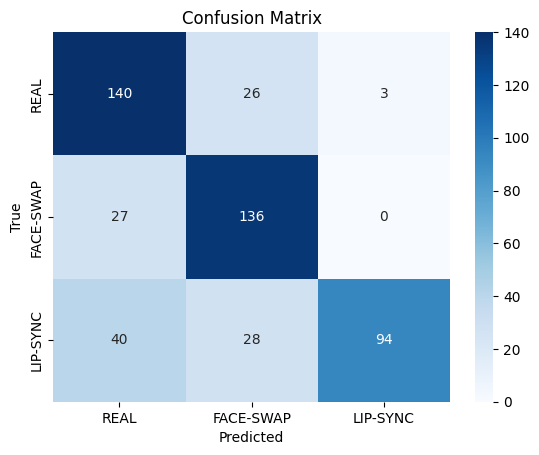

AUC Score (macro): 0.8108


In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename)
    label_name = video_info["label"]
    true_label = label_map[label_name]
    
    print(f"\n📹 Video: {filename}")
    print(f"   Ground Truth : {label_name}")

    result_1 = predict_face(video_path)
    if result_1 is None:
        print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
    else:
        print(f"   Confidence Face Model  : REAL={result_1[0][0]:.4f}, FACE-SWAP={result_1[0][1]:.4f}")
    
    if result_1 is not None and result_1[1] == 1:
        final_pred = 1

    else:
        result_2 = predict_lip_audio(video_path)
        
        if result_2 is None:
            print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
            continue
        else:
            print(f"   Confidence Lip-Audio Model  : REAL={result_2[0][0]:.4f}, LIP-SYNC={result_2[0][1]:.4f}")
            final_pred = 2 if result_2[1] == 1 else 0

    print(f"   Predicted Model : {list(label_map.keys())[final_pred]}")
    
    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)

# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FACE-SWAP", "LIP-SYNC"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"],
            yticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred, classes=[0,1,2])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

-------------------------------------

**Hasil Testing Sistem Deepfake (Deteksi Wajah Deepfake - Deteksi Lipsync Deepfake)**

3 Label (REAL, FACE-SWAP DEEPFAKE, LIP-SYNC DEEPFAKE)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings


📹 Video: aabyjxwqyo.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0294, FACE-SWAP=0.9706
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: aaeflzzhvy.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0382, FACE-SWAP=0.9618
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: accfrqkrni.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0455, FACE-SWAP=0.9545
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: adfzvplbky.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
[SKIP] Dataset/testing\adfzvplbky.mp4: hanya 47 frame wajah < seharusnya 50 berdasarkan 10.03s
[SKIP] Wajah tidak terdeteksi di adfzvplbky.mp4
[SKIP] frame 0: belum ada wajah valid
[SKIP] frame 6: belum ada wajah valid
[SKIP] frame 12: belum ada wajah valid
[SKIP] frame 18: belum ada wajah valid
[SKIP] frame 24: belum ada wajah valid
[SKIP] frame 30: belum ada wajah valid
[SKIP] frame 36: belum ada wajah valid
[SKIP] frame 42: belum ada wajah valid
[SKIP

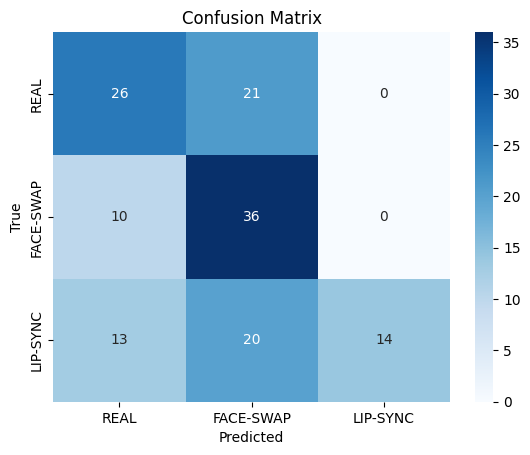

AUC Score (macro): 0.6584


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


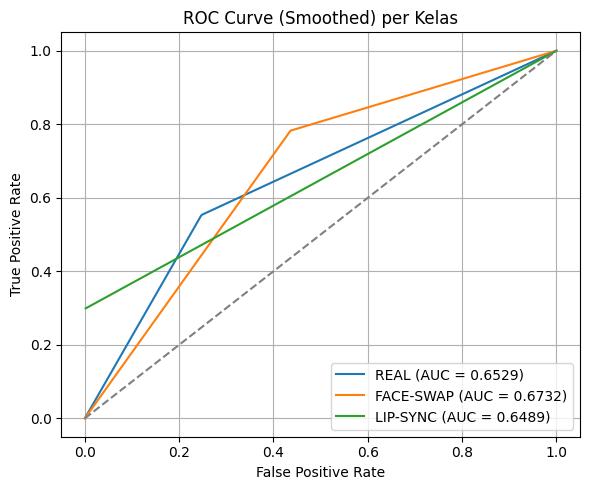

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename)
    label_name = video_info["label"]
    true_label = label_map[label_name]
    
    print(f"\n📹 Video: {filename}")
    print(f"   Ground Truth : {label_name}")

    result_1 = predict_face(video_path)
    if result_1 is None:
        print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
    else:
        print(f"   Confidence Face Model  : REAL={result_1[0][0]:.4f}, FACE-SWAP={result_1[0][1]:.4f}")
    
    if result_1 is not None and result_1[1] == 1:
        final_pred = 1

    else:
        result_2 = predict_lip_audio(video_path)
        
        if result_2 is None:
            print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
            continue
        else:
            print(f"   Confidence Lip-Audio Model  : REAL={result_2[0][0]:.4f}, LIP-SYNC={result_2[0][1]:.4f}")
            final_pred = 2 if result_2[1] == 1 else 0

    print(f"   Predicted Model : {list(label_map.keys())[final_pred]}")
    
    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)
    
# Simpan Hasil
import pandas as pd

# Buat DataFrame hasil evaluasi
results = pd.DataFrame({
    "video_name": video_filenames_logged,
    "ground_truth": [list(label_map.keys())[list(label_map.values()).index(lbl)] for lbl in y_true],
    "predicted": [list(label_map.keys())[list(label_map.values()).index(lbl)] for lbl in y_pred]
})

# # Simpan ke file Excel
output_excel_path = "hasil_prediksi_deepfake_faceswap_first.xlsx"
results.to_excel(output_excel_path, index=False)

#  Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FACE-SWAP", "LIP-SYNC"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"],
            yticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred, classes=[0,1,2])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

for i, class_name in enumerate(["REAL", "FACE-SWAP", "LIP-SYNC"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    auc_score = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr_smooth, tpr_smooth, label=f"{class_name} (AUC = {auc_score:.4f})")

# Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed) per Kelas')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Hasil Testing Sistem Deepfake (Deteksi Wajah Deepfake - Deteksi Lipsync Deepfake)**

2 Label (REAL & FAKE)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

[SKIP] Dataset/testing\adfzvplbky.mp4: hanya 47 frame wajah < seharusnya 50 berdasarkan 10.03s
[SKIP] Wajah tidak terdeteksi di adfzvplbky.mp4
[SKIP] frame 0: belum ada wajah valid
[SKIP] frame 6: belum ada wajah valid
[SKIP] frame 12: belum ada wajah valid
[SKIP] frame 18: belum ada wajah valid
[SKIP] frame 24: belum ada wajah valid
[SKIP] frame 30: belum ada wajah valid
[SKIP] frame 36: belum ada wajah valid
[SKIP] frame 42: belum ada wajah valid
[SKIP] frame 48: belum ada wajah valid
[SKIP] frame 55: belum ada wajah valid
[SKIP] frame 61: belum ada wajah valid
[SKIP] Dataset/testing\adfzvplbky.mp4: hanya 39 frame bibir < seharusnya 50 berdasarkan 10.03s
[SKIP] Bibir/Audio tidak terdeteksi di adfzvplbky.mp4
[SKIP] Dataset/testing\adrqlckutl.mp4: hanya 49 frame wajah < seharusnya 50 berdasarkan 10.03s
[SKIP] Wajah tidak terdeteksi di adrqlckutl.mp4
[SKIP] frame 0: belum ada wajah valid
[SKIP] Dataset/testing\adrqlckutl.mp4: hanya 49 frame bibir < seharusnya 50 berdasarkan 10.03s
[SKIP

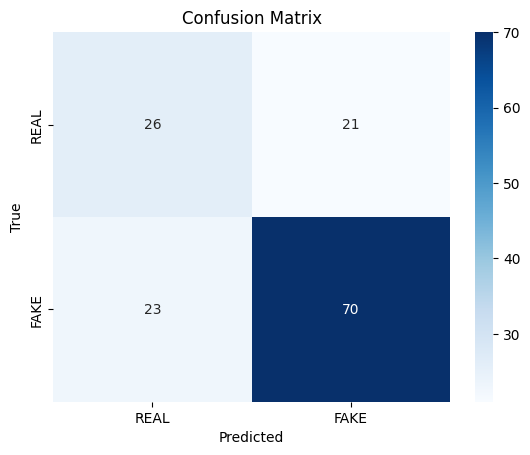

AUC Score (macro): 0.6529


<Figure size 600x500 with 0 Axes>

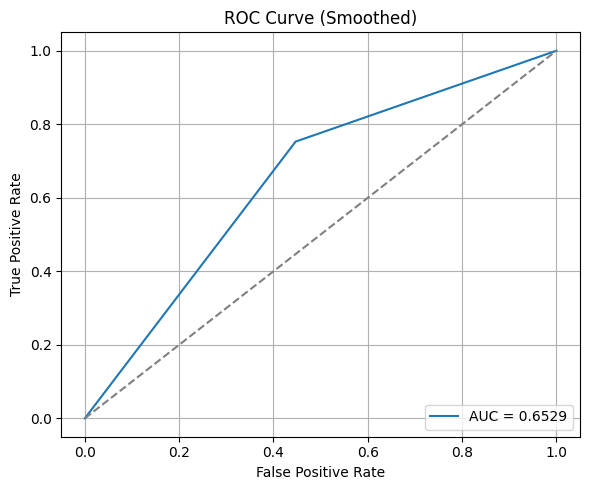

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 1
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = FACE-SWAP

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram (implementasi tergantung dataset)
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    # Kalau salah satu None (gagal ekstraksi), prediksi FAKE (LIP-SYNC DEEPFAKE)
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)  # (1, T, 3, 224, 224)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)    # (1, 1, F, T)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = LIP-SYNC

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing"

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename, {"label": "REAL"})  # default: label REAL kalau tidak ketemu
    label_name = video_info["label"]                        # ambil labelnya
    true_label = label_map[label_name]                      # map ke angka 0/1/2

    face_result = predict_face(video_path)
    if face_result is None:
        print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
    
    if face_result is not None and face_result == 1:
        final_pred = 1
    else:
        lip_result = predict_lip_audio(video_path)
        
        if lip_result is None:
            print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
            continue  # skip video ini
        
        final_pred = 1 if lip_result == 1 else 0

    y_true.append(true_label)
    y_pred.append(final_pred)

# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FAKE"],
            yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1])
y_pred_bin = label_binarize(y_pred, classes=[0,1])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

fpr_smooth = np.linspace(0, 1, 500)
tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Coba Model Deteksi Face-Swap 100% benar**

3 Label

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings


📹 Video: aabyjxwqyo.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0294, FACE-SWAP=0.9706
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: aaeflzzhvy.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0382, FACE-SWAP=0.9618
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: accfrqkrni.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0455, FACE-SWAP=0.9545
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: adsxwxeibr.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Face Model  : REAL=0.0441, FACE-SWAP=0.9559
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: alzbizkswy.mp4
   Ground Truth : REAL
   Confidence Face Model  : REAL=0.5917, FACE-SWAP=0.4083
   Confidence Lip-Audio Model  : REAL=0.9032, LIP-SYNC=0.0968
   Predicted Model : REAL

📹 Video: alzbizkswy_lipsync.mp4
   Ground Truth : LIP-SYNC DEEPFAKE
   Confidence Face Model  : REAL=0.6086, FACE-SWAP=0.3914
   Confidence Lip-Audio Model  : REAL=0

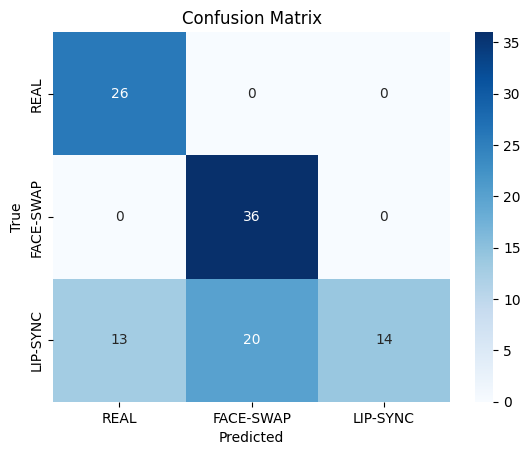

AUC Score (macro): 0.8112


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


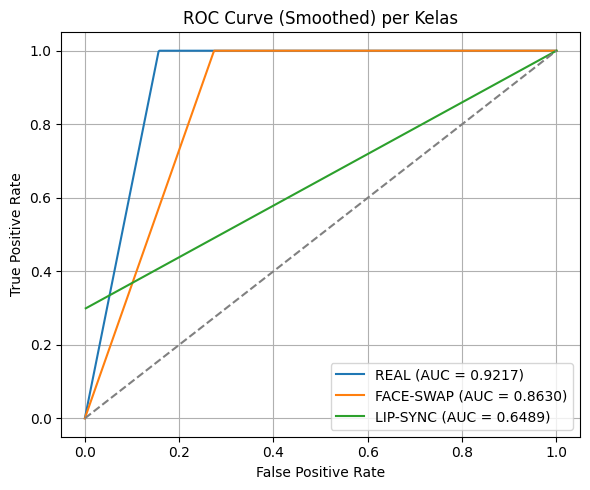

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing_CNN-BiLSTM"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename)
    label_name = video_info["label"]
    true_label = label_map[label_name]
    
    print(f"\n📹 Video: {filename}")
    print(f"   Ground Truth : {label_name}")

    result_1 = predict_face(video_path)
    if result_1 is None:
        print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
    else:
        print(f"   Confidence Face Model  : REAL={result_1[0][0]:.4f}, FACE-SWAP={result_1[0][1]:.4f}")
    
    if result_1 is not None and result_1[1] == 1:
        final_pred = 1

    else:
        result_2 = predict_lip_audio(video_path)
        
        if result_2 is None:
            print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
            continue
        else:
            print(f"   Confidence Lip-Audio Model  : REAL={result_2[0][0]:.4f}, LIP-SYNC={result_2[0][1]:.4f}")
            final_pred = 2 if result_2[1] == 1 else 0

    print(f"   Predicted Model : {list(label_map.keys())[final_pred]}")
    
    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)
    

#  Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FACE-SWAP", "LIP-SYNC"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"],
            yticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred, classes=[0,1,2])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

for i, class_name in enumerate(["REAL", "FACE-SWAP", "LIP-SYNC"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    auc_score = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr_smooth, tpr_smooth, label=f"{class_name} (AUC = {auc_score:.4f})")

# Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed) per Kelas')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Coba Model Deteksi Face-Swap 100% benar**

2 Label

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        REAL       0.67      1.00      0.80        26
        FAKE       1.00      0.84      0.92        83

    accuracy                           0.88       109
   macro avg       0.83      0.92      0.86       109
weighted avg       0.92      0.88      0.89       109


=== CONFUSION MATRIX ===


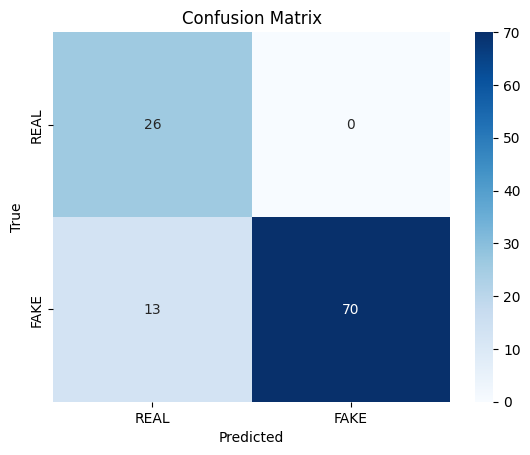

AUC Score (macro): 0.9217


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


<Figure size 600x500 with 0 Axes>

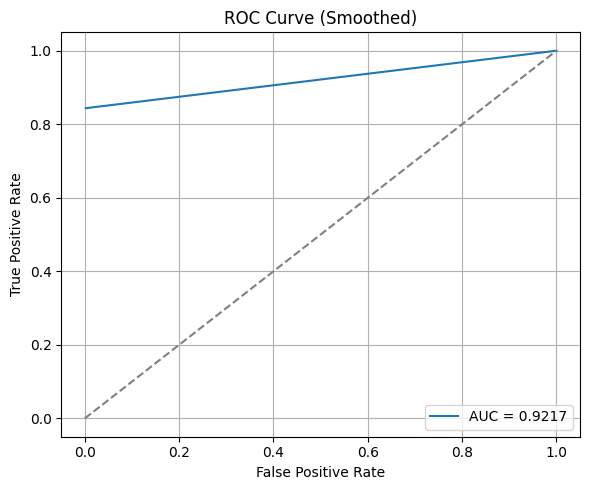

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 1
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = FACE-SWAP

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    # Kalau salah satu None (gagal ekstraksi), prediksi FAKE (LIP-SYNC DEEPFAKE)
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)  # (1, T, 3, 224, 224)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)    # (1, 1, F, T)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = LIP-SYNC

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing_CNN-BiLSTM"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dict info
    video_info = metadata.get(filename, {"label": "REAL"})  # default: label REAL kalau tidak ketemu
    label_name = video_info["label"]                        # ambil labelnya
    true_label = label_map[label_name]                      # map ke angka 0/1/2

    face_result = predict_face(video_path)
    if face_result is None:
        print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
    
    if face_result is not None and face_result == 1:
        final_pred = 1
    else:
        lip_result = predict_lip_audio(video_path)
        
        if lip_result is None:
            print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
            continue  # skip video ini
        
        final_pred = 1 if lip_result == 1 else 0

    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)

# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FAKE"],
            yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1])
y_pred_bin = label_binarize(y_pred, classes=[0,1])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

fpr_smooth = np.linspace(0, 1, 500)
tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Hasil Testing Sistem Deepfake (Deteksi Lipsync Deepfake - Deteksi Wajah Deepfake)**

3 Label (REAL, FACE-SWAP DEEPFAKE, LIP-SYNC DEEPFAKE)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings


📹 Video: aabyjxwqyo.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.9144, LIP-SYNC=0.0856
   Confidence Face Model  : REAL=0.0294, FACE-SWAP=0.9706
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: aaeflzzhvy.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.8514, LIP-SYNC=0.1486
   Confidence Face Model  : REAL=0.0382, FACE-SWAP=0.9618
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: accfrqkrni.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.8996, LIP-SYNC=0.1004
   Confidence Face Model  : REAL=0.0455, FACE-SWAP=0.9545
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: adfzvplbky.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
[SKIP] frame 0: belum ada wajah valid
[SKIP] frame 6: belum ada wajah valid
[SKIP] frame 12: belum ada wajah valid
[SKIP] frame 18: belum ada wajah valid
[SKIP] frame 24: belum ada wajah valid
[SKIP] frame 30: belum ada wajah valid
[SKIP] frame 36: belum ada wajah valid
[

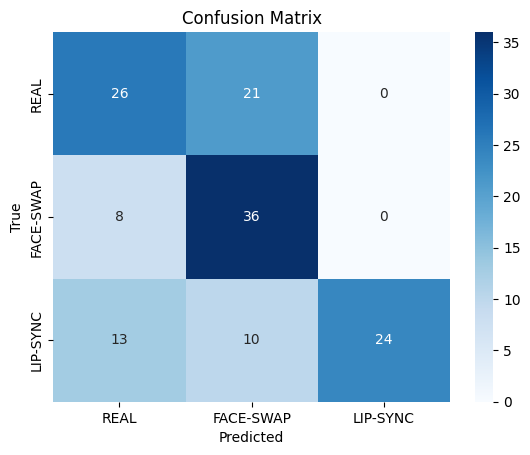

AUC Score (macro): 0.7202


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


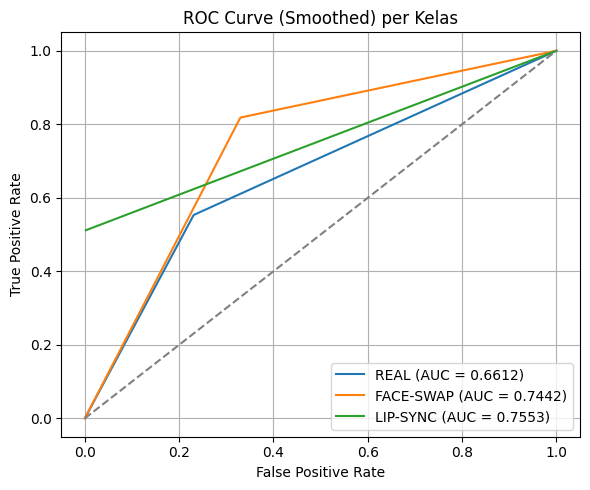

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename)
    label_name = video_info["label"]
    true_label = label_map[label_name]
    
    print(f"\n📹 Video: {filename}")
    print(f"   Ground Truth : {label_name}")

    result_1 = predict_lip_audio(video_path)
    if result_1 is None:
        print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
    else:
        print(f"   Confidence Lip-Audio Model  : REAL={result_1[0][0]:.4f}, LIP-SYNC={result_1[0][1]:.4f}")
    
    if result_1 is not None and result_1[1] == 1:
        final_pred = 2

    else:
        result_2 = predict_face(video_path)
        
        if result_2 is None:
            print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
            continue
        else:
            print(f"   Confidence Face Model  : REAL={result_2[0][0]:.4f}, FACE-SWAP={result_2[0][1]:.4f}")
            final_pred = 1 if result_2[1] == 1 else 0

    print(f"   Predicted Model : {list(label_map.keys())[final_pred]}")
    
    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)
    
# Simpan Hasil
import pandas as pd

# Buat DataFrame hasil evaluasi
results = pd.DataFrame({
    "video_name": video_filenames_logged,
    "ground_truth": [list(label_map.keys())[list(label_map.values()).index(lbl)] for lbl in y_true],
    "predicted": [list(label_map.keys())[list(label_map.values()).index(lbl)] for lbl in y_pred]
})

# Simpan ke file Excel
output_excel_path = "hasil_prediksi_deepfake_lipsync_first.xlsx"
results.to_excel(output_excel_path, index=False)

# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FACE-SWAP", "LIP-SYNC"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"],
            yticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred, classes=[0,1,2])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

for i, class_name in enumerate(["REAL", "FACE-SWAP", "LIP-SYNC"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    auc_score = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr_smooth, tpr_smooth, label=f"{class_name} (AUC = {auc_score:.4f})")

# Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed) per Kelas')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Hasil Testing Sistem Deepfake (Deteksi Lipsync Deepfake - Deteksi Wajah Deepfake)**

2 Label (REAL & FAKE)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

[SKIP] frame 0: belum ada wajah valid
[SKIP] frame 6: belum ada wajah valid
[SKIP] frame 12: belum ada wajah valid
[SKIP] frame 18: belum ada wajah valid
[SKIP] frame 24: belum ada wajah valid
[SKIP] frame 30: belum ada wajah valid
[SKIP] frame 36: belum ada wajah valid
[SKIP] frame 42: belum ada wajah valid
[SKIP] frame 48: belum ada wajah valid
[SKIP] frame 55: belum ada wajah valid
[SKIP] frame 61: belum ada wajah valid
[SKIP] Dataset/testing\adfzvplbky.mp4: hanya 39 frame bibir < seharusnya 50 berdasarkan 10.03s
[SKIP] Bibir/Audio tidak terdeteksi di adfzvplbky.mp4
[SKIP] Dataset/testing\adfzvplbky.mp4: hanya 47 frame wajah < seharusnya 50 berdasarkan 10.03s
[SKIP] Wajah tidak terdeteksi di adfzvplbky.mp4
[SKIP] frame 0: belum ada wajah valid
[SKIP] Dataset/testing\adrqlckutl.mp4: hanya 49 frame bibir < seharusnya 50 berdasarkan 10.03s
[SKIP] Bibir/Audio tidak terdeteksi di adrqlckutl.mp4
[SKIP] Dataset/testing\adrqlckutl.mp4: hanya 49 frame wajah < seharusnya 50 berdasarkan 10.03s

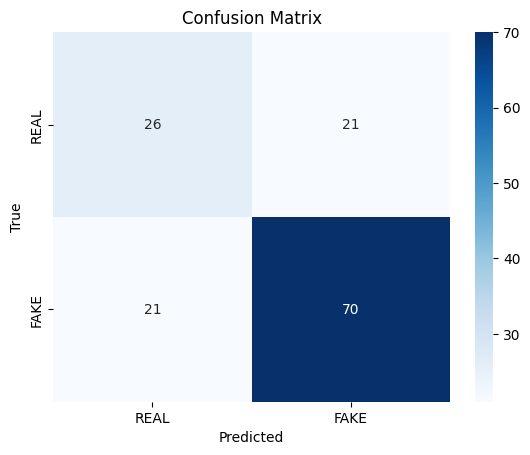

AUC Score (macro): 0.6612


<Figure size 600x500 with 0 Axes>

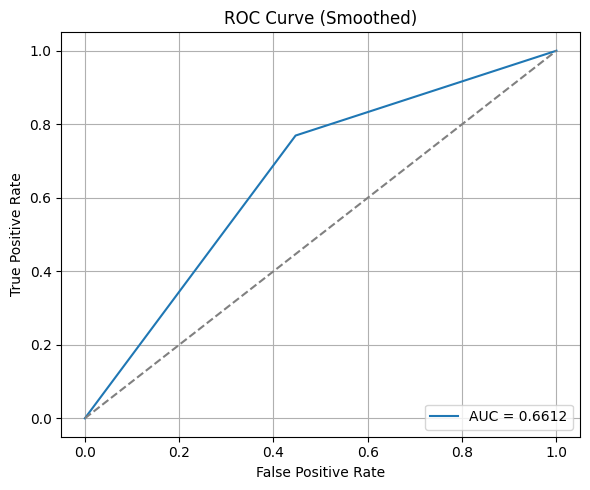

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F_new_1e-4_percobaan2.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 1
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = FACE-SWAP

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    # Kalau salah satu None (gagal ekstraksi), prediksi FAKE (LIP-SYNC DEEPFAKE)
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)  # (1, T, 3, 224, 224)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)    # (1, 1, F, T)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = LIP-SYNC

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename, {"label": "REAL"})
    label_name = video_info["label"] 
    true_label = label_map[label_name]
        
    lip_result = predict_lip_audio(video_path)
    if lip_result is None:
            print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
    
    if lip_result is not None and lip_result == 1:
        final_pred = 1
    else:
        face_result = predict_face(video_path)
        if face_result is None:
            print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
            continue
        final_pred = 1 if face_result == 1 else 0
        

    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)

# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FAKE"],
            yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1])
y_pred_bin = label_binarize(y_pred, classes=[0,1])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

fpr_smooth = np.linspace(0, 1, 500)
tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings


📹 Video: aabyjxwqyo.mp4
   Ground Truth : FACE-SWAP DEEPFAKE


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


   Confidence Lip-Audio Model  : REAL=0.9144, LIP-SYNC=0.0856
   Confidence Face Model  : REAL=0.0294, FACE-SWAP=0.9706
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: aaeflzzhvy.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.8514, LIP-SYNC=0.1486
   Confidence Face Model  : REAL=0.0382, FACE-SWAP=0.9618
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: accfrqkrni.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.8996, LIP-SYNC=0.1004
   Confidence Face Model  : REAL=0.0455, FACE-SWAP=0.9545
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: adsxwxeibr.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.9427, LIP-SYNC=0.0573
   Confidence Face Model  : REAL=0.0441, FACE-SWAP=0.9559
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: alzbizkswy.mp4
   Ground Truth : REAL
   Confidence Lip-Audio Model  : REAL=0.9032, LIP-SYNC=0.0968
   Confidence Face Model  : REAL=0.5917, FACE-SWAP=0.4083
   Pre

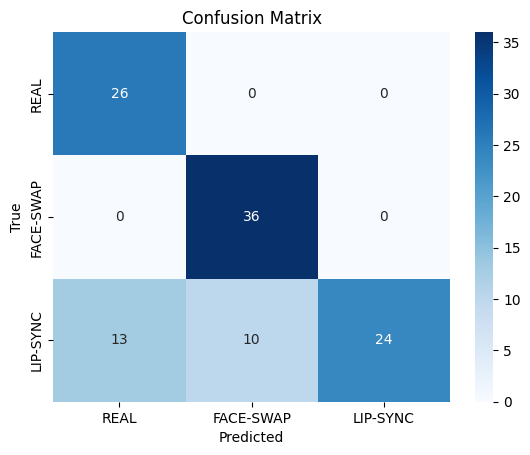

AUC Score (macro): 0.8695


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


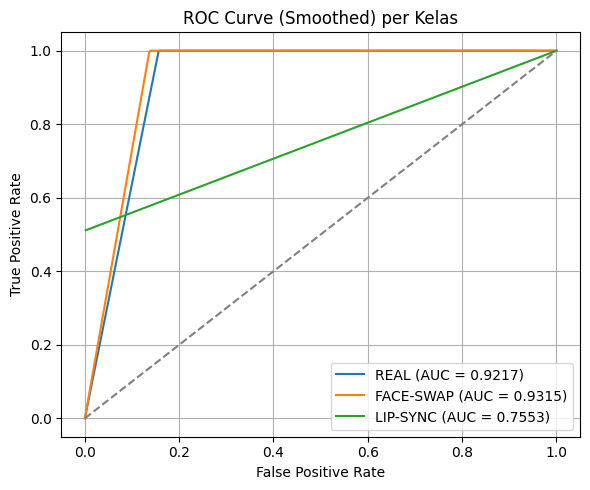

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing_lip_sync_model_new2"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename)
    label_name = video_info["label"]
    true_label = label_map[label_name]
    
    print(f"\n📹 Video: {filename}")
    print(f"   Ground Truth : {label_name}")

    result_1 = predict_lip_audio(video_path)
    if result_1 is None:
        print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
    else:
        print(f"   Confidence Lip-Audio Model  : REAL={result_1[0][0]:.4f}, LIP-SYNC={result_1[0][1]:.4f}")
    
    if result_1 is not None and result_1[1] == 1:
        final_pred = 2

    else:
        result_2 = predict_face(video_path)
        
        if result_2 is None:
            print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
            continue
        else:
            print(f"   Confidence Face Model  : REAL={result_2[0][0]:.4f}, FACE-SWAP={result_2[0][1]:.4f}")
            final_pred = 1 if result_2[1] == 1 else 0

    print(f"   Predicted Model : {list(label_map.keys())[final_pred]}")
    
    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)


# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FACE-SWAP", "LIP-SYNC"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"],
            yticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred, classes=[0,1,2])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

for i, class_name in enumerate(["REAL", "FACE-SWAP", "LIP-SYNC"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    auc_score = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr_smooth, tpr_smooth, label=f"{class_name} (AUC = {auc_score:.4f})")

# Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed) per Kelas')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Coba Model Deteksi Face-Swap 100% benar Lipsync model pertama**

2 Label

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

[SKIP] frame 0: belum ada wajah valid
[SKIP] frame 6: belum ada wajah valid
[SKIP] frame 12: belum ada wajah valid
[SKIP] frame 18: belum ada wajah valid
[SKIP] frame 24: belum ada wajah valid
[SKIP] frame 30: belum ada wajah valid
[SKIP] frame 36: belum ada wajah valid
[SKIP] frame 42: belum ada wajah valid
[SKIP] Dataset/testing_lip_sync_model_new2\evyqbkbsiv.mp4: hanya 42 frame bibir < seharusnya 50 berdasarkan 10.01s
[SKIP] Bibir/Audio tidak terdeteksi di evyqbkbsiv.mp4
[SKIP] frame 0: belum ada wajah valid
[SKIP] Dataset/testing_lip_sync_model_new2\ooavdkhcnf_lipsync.mp4: hanya 49 frame bibir < seharusnya 50 berdasarkan 10.03s
[SKIP] Bibir/Audio tidak terdeteksi di ooavdkhcnf_lipsync.mp4
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        REAL       0.67      1.00      0.80        26
        FAKE       1.00      0.84      0.92        83

    accuracy                           0.88       109
   macro avg       0.83      0.92      0.86       

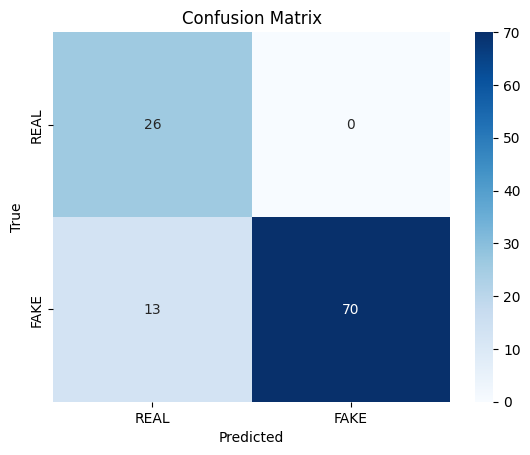

AUC Score (macro): 0.9217


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


<Figure size 600x500 with 0 Axes>

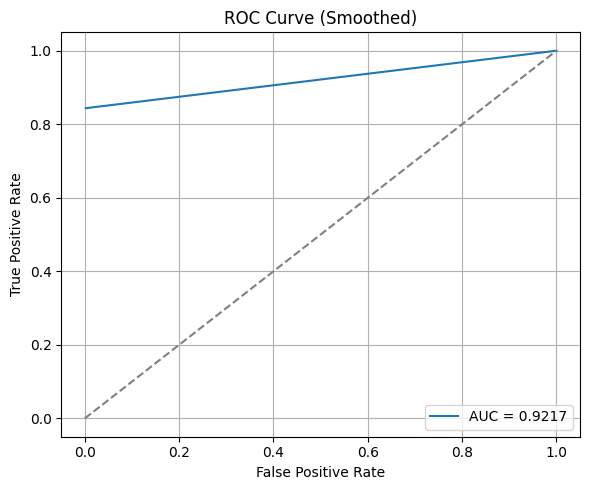

In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/testing/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 1
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = FACE-SWAP

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    # Kalau salah satu None (gagal ekstraksi), prediksi FAKE (LIP-SYNC DEEPFAKE)
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)  # (1, T, 3, 224, 224)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)    # (1, 1, F, T)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        pred = torch.argmax(out, dim=1).item()
    return pred  # 0 = REAL, 1 = LIP-SYNC

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/testing_lip_sync_model_new2"
video_filenames_logged = []

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename, {"label": "REAL"})  # default: label REAL kalau tidak ketemu
    label_name = video_info["label"]                        # ambil labelnya
    true_label = label_map[label_name]                      # map ke angka 0/1/2

    lip_result = predict_lip_audio(video_path)
    if lip_result is None:
        print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
    
    if lip_result is not None and lip_result == 1:
        final_pred = 1
    else:
        face_result = predict_face(video_path)
        
        if face_result is None:
            print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
            continue  # skip video ini
        
        final_pred = 1 if face_result == 1 else 0

    y_true.append(true_label)
    y_pred.append(final_pred)
    video_filenames_logged.append(filename)

# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FAKE"],
            yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1])
y_pred_bin = label_binarize(y_pred, classes=[0,1])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")

from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

plt.figure(figsize=(6, 5))

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

fpr_smooth = np.linspace(0, 1, 500)
tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Smoothed)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

-------------------------------------

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings


📹 Video: abhlupreiy.mp4
   Ground Truth : FACE-SWAP DEEPFAKE


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


   Confidence Lip-Audio Model  : REAL=0.8658, LIP-SYNC=0.1342
   Confidence Face Model  : REAL=0.0243, FACE-SWAP=0.9757
   Predicted Model : FACE-SWAP DEEPFAKE

📹 Video: abmcjolywn.mp4
   Ground Truth : REAL
   Confidence Lip-Audio Model  : REAL=0.9428, LIP-SYNC=0.0572
   Confidence Face Model  : REAL=0.9660, FACE-SWAP=0.0340
   Predicted Model : REAL

📹 Video: abmcjolywn_lipsync.mp4
   Ground Truth : LIP-SYNC DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.8321, LIP-SYNC=0.1679
   Confidence Face Model  : REAL=0.9635, FACE-SWAP=0.0365
   Predicted Model : REAL

📹 Video: adqgbsyomi.mp4
   Ground Truth : REAL
   Confidence Lip-Audio Model  : REAL=0.8879, LIP-SYNC=0.1121
   Confidence Face Model  : REAL=0.9683, FACE-SWAP=0.0317
   Predicted Model : REAL

📹 Video: adqgbsyomi_lipsync.mp4
   Ground Truth : LIP-SYNC DEEPFAKE
   Confidence Lip-Audio Model  : REAL=0.0456, LIP-SYNC=0.9544
   Predicted Model : LIP-SYNC DEEPFAKE

📹 Video: agwbtwcwwq.mp4
   Ground Truth : FACE-SWAP DEEPFAKE
   Co

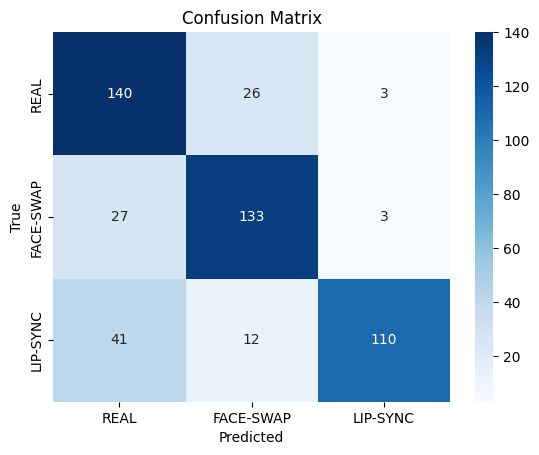

AUC Score (macro): 0.8297


In [ ]:
import torch
import json
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

face_model = DeepfakeClassifier()
face_model.load_state_dict(torch.load("Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth", map_location=device))
lip_model = MultimodalLipSyncDetector()
lip_model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))

face_model.eval()
lip_model.eval()

face_model.to(device)
lip_model.to(device)

# Load Metadata
with open("Dataset/metadata.json", "r") as f:
    metadata = json.load(f)

label_map = {
    "REAL": 0,
    "FACE-SWAP DEEPFAKE": 1,
    "LIP-SYNC DEEPFAKE": 2
}

# Helper Fungsi
def predict_face(video_path):
    # Fungsi ekstraksi + prediksi wajah
    face_res = extract_frames_from_video(video_path)  # (T, 3, 224, 224)
    
    if face_res is None:
        return None
    
    face_frames = face_res
    
    face_tensor = torch.stack(face_frames).unsqueeze(0)  # (1, T, 3, 224, 224)

    with torch.no_grad():
        out = face_model(face_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

def predict_lip_audio(video_path):
    # Fungsi ekstraksi bibir + mel spectrogram
    lip_res = extract_lips_audio_tensor(video_path)  # shapes: ( T, 3, 224, 224), (1, F, T')
    
    if lip_res is None : 
        return None
    
    lips_frames, audio_tensor = lip_res
    
    if lips_frames is None or audio_tensor is None:
        return None
    
    lips_tensor = lips_frames.unsqueeze(0)
    
    if audio_tensor.max() > 1.0 or audio_tensor.min() < 0.0:
            audio_tensor = torch.clamp(audio_tensor, min=-80, max=0) 
            audio_tensor = (audio_tensor + 80) / 80
    
    audio_tensor = audio_tensor.unsqueeze(0)
    
    with torch.no_grad():
        out = lip_model(lips_tensor.to(device), audio_tensor.to(device))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = torch.argmax(out, dim=1).item()
    return probs, pred

# Evaluasi
y_true = []
y_pred = []

video_folder = "Dataset/"

for filename in os.listdir(video_folder):
    if not filename.endswith(".mp4"):
        continue

    video_path = os.path.join(video_folder, filename)
    # ambil dictionary info
    video_info = metadata.get(filename)
    label_name = video_info["label"]
    true_label = label_map[label_name]
    
    print(f"\n📹 Video: {filename}")
    print(f"   Ground Truth : {label_name}")

    result_1 = predict_lip_audio(video_path)
    if result_1 is None:
        print(f"[SKIP] Bibir/Audio tidak terdeteksi di {filename}")
        
    else:
        print(f"   Confidence Lip-Audio Model  : REAL={result_1[0][0]:.4f}, LIP-SYNC={result_1[0][1]:.4f}")
        
    
    if result_1 is not None and result_1[1] == 1:
        final_pred = 2

    else:
        result_2 = predict_face(video_path)
        
        if result_2 is None:
            print(f"[SKIP] Wajah tidak terdeteksi di {filename}")
            continue
        else:
            print(f"   Confidence Face Model  : REAL={result_2[0][0]:.4f}, FACE-SWAP={result_2[0][1]:.4f}")
            final_pred = 1 if result_2[1] == 1 else 0

    print(f"   Predicted Model : {list(label_map.keys())[final_pred]}")
    
    y_true.append(true_label)
    y_pred.append(final_pred)

# Hasil Evaluasi
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["REAL", "FACE-SWAP", "LIP-SYNC"]))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"],
            yticklabels=["REAL", "FACE-SWAP", "LIP-SYNC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Macro
y_true_bin = label_binarize(y_true, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred, classes=[0,1,2])
auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUC Score (macro): {auc:.4f}")